# Kaggle Titanic challenge

To be done: restrict to 80 characters per line

## Table of contents

1. [Setup](#Setup)
2. [Exploratory analysis](#Exploratory-analysis) 
3. [Data cleaning](#Data-cleaning)
4. [Feature generation](#Feature-generation)
5. [Modeling](#Modeling)

## Setup

_[<sup>Return to beginning of notebook</sup>](#Kaggle-Titanic-challenge)_

### Imports

In [28]:
# Load system libraries.
import os
import re
import sys
import collections
import functools
import logging
logging.basicConfig(
    format='%(asctime)s %(message)s', 
    datefmt='%H:%M:%S',
    level=logging.INFO, 
    stream=sys.stdout
)

# Libraries for data wrangling.
import numpy as np
import pandas as pd
import scipy as sc
import sklearn
import joblib
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Machine learning.
from sklearn import preprocessing
from sklearn import model_selection

from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Visualization libraries.
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_context('poster')
sns.set(rc={'figure.figsize': (3, 3)})
sns.set_style('whitegrid')
tqdm = functools.partial(tqdm.tqdm, file=sys.stdout, position=0, leave=True)

# Local modules.
%load_ext autoreload
%autoreload 2
from src import kaggle_api, titanic

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data

In [2]:
# Load the train and test data.
train = pd.read_csv('data/train.csv', index_col='PassengerId')
test = pd.read_csv('data/test.csv', index_col='PassengerId')
train_test = pd.concat([train, test])

train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Exploratory analysis

_[<sup>Return to beginning of notebook</sup>](#Kaggle-Titanic-challenge)_

What type of columns do we have, and what are their distributions?

In [3]:
print('Numerical columns:')
display(train.describe(include=np.number))
print('Categorical columns:')
display(train.describe(exclude=np.number))
print('Missing values:')
display(pd.concat([
    train.iloc[:, 1:].isna().sum().rename('train'),
    test.isna().sum().rename('test')
], axis=1))

Numerical columns:


,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Categorical columns:


,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Hirvonen, Miss. Hildur E",male,1601,C23 C25 C27,S
freq,1,577,7,4,644


Missing values:


,train,test
Pclass,0,0
Name,0,0
Sex,0,0
Age,177,86
SibSp,0,0
Parch,0,0
Ticket,0,0
Fare,0,1
Cabin,687,327
Embarked,2,0


The data inclues 10 columns of different types and complexity:
- Simple categorical values: `Sex`, `Embarked`, and `Pclass`.
- Discrete values: `SibSp` and `Parch`.
- Continuous values: `Age` (slightly skewed) and `Fare` (highly skewed).
- More complex values: `Ticket`, `Cabin`, and `Name`.

_Note: `Age` and `Cabin` contain many missing values._

### Simple categorical values

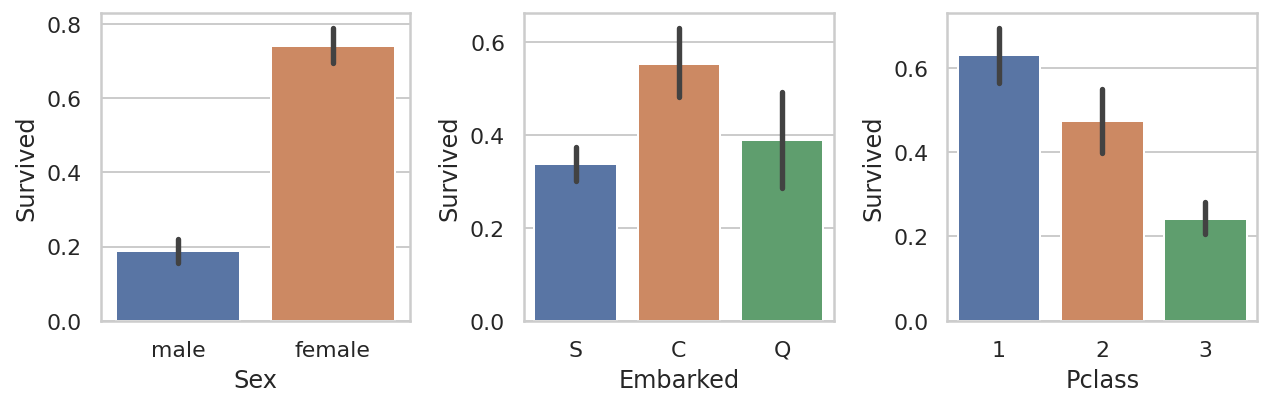

In [4]:
categorical_columns = ['Sex', 'Embarked', 'Pclass']

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
for i, categorical_column in enumerate(categorical_columns):
    sns.barplot(data=train, x=categorical_column, y='Survived', ax=axes[i])
plt.tight_layout()

All categorical values are strongly indicative of survival. Females, first-class tickets holders, and passengers that embarked at Cherbourg have the highest survival rates.

### Discrete values

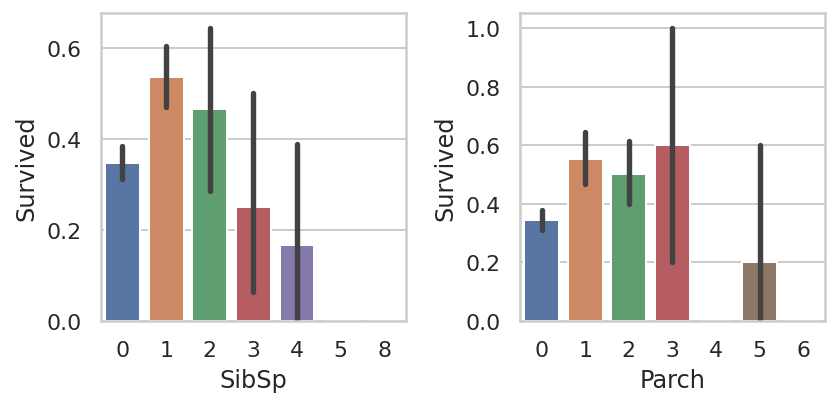

In [5]:
discrete_columns = ['SibSp', 'Parch']

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
for i, categorical_column in enumerate(discrete_columns):
    sns.barplot(data=train, x=categorical_column, y='Survived', ax=axes[i])
plt.tight_layout()

The number of relatives is moderately indicative of survival. Passengers without any relatives are less likely to survive. 

### Continuous values

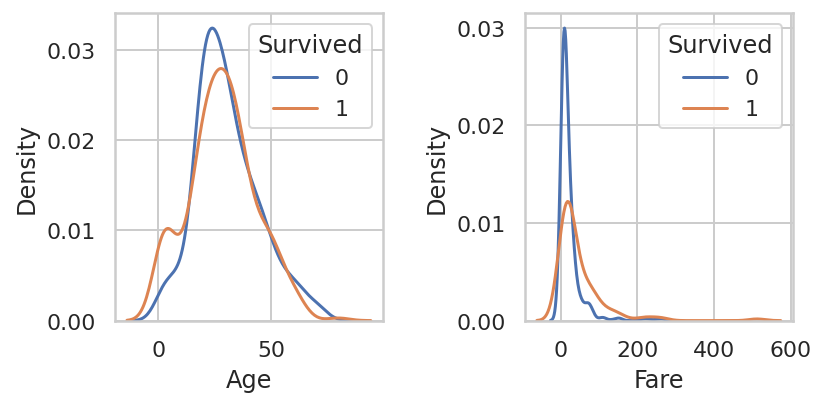

In [6]:
discrete_columns = ['Age', 'Fare']

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
for i, categorical_column in enumerate(discrete_columns):
    sns.kdeplot(data=train[train['Survived'] == 0], x=categorical_column, ax=axes[i], label='0')
    sns.kdeplot(data=train[train['Survived'] == 1], x=categorical_column, ax=axes[i], label='1')
    axes[i].legend(title='Survived')
plt.tight_layout()

Both age and fare are weakly indicative of survival. A higher fare correlates with higher survival rate (possibly because of a better ticket class), and younger passengers are more likely to survive.

### More complex values

#### Name

In [7]:
train['Name'].sort_values().head()

PassengerId
846                      Abbing, Mr. Anthony
747              Abbott, Mr. Rossmore Edward
280         Abbott, Mrs. Stanton (Rosa Hunt)
309                      Abelson, Mr. Samuel
875    Abelson, Mrs. Samuel (Hannah Wizosky)
Name: Name, dtype: object

The name of the passenger includes their title, i.e. their social status, which could be indicate of survival. In addition, the last name of the passengers could indicate familes that traveled together, and may have similar fates.

#### Cabin number

In [8]:
train.loc[~train['Cabin'].isna(), 'Cabin'].sample(50).sort_values().to_numpy()

array(['A16', 'A20', 'A24', 'A26', 'A31', 'B39', 'B4', 'B41', 'B5', 'B69',
       'B78', 'B96 B98', 'C101', 'C103', 'C104', 'C123', 'C125', 'C128',
       'C22 C26', 'C22 C26', 'C23 C25 C27', 'C23 C25 C27', 'C50', 'C65',
       'C65', 'C7', 'C90', 'C92', 'D10 D12', 'D17', 'D28', 'D37', 'D45',
       'D47', 'D49', 'D50', 'E12', 'E33', 'E34', 'E44', 'E46', 'E58',
       'E67', 'E67', 'E8', 'F E69', 'F G63', 'F G73', 'F33', 'F38'],
      dtype=object)

The cabin number includes the deck (the letter of `Cabin`). It also indicates whether the cabin is in the bow or stern of the ship, as lower numbers are towards the stern, and higher numbers are towards the bow. Finally, similar to the last name, some passengers shared the same cabin, which could indicate similar fates.

#### Ticket number

In [9]:
train['Ticket'].sample(50).sort_values().to_numpy()

array(['110813', '112059', '113050', '113788', '12233', '19928', '19972',
       '239854', '250643', '250651', '2620', '2666', '2668', '2685',
       '28403', '28664', '29103', '342826', '345769', '347061', '349206',
       '349207', '349214', '349221', '349237', '349247', '349256',
       '349912', '35281', '36209', '365226', '370129', '370373', '371110',
       '382649', '693', 'A/S 2816', 'C.A. 2315', 'C.A. 33112',
       'C.A. 33595', 'LINE', 'PC 17476', 'PC 17477', 'PC 17485',
       'PC 17582', 'S.O./P.P. 3', 'SC/PARIS 2133', 'SOTON/O.Q. 392087',
       'SOTON/OQ 392090', 'STON/O 2. 3101289'], dtype=object)

Some ticket numbers include letters indicative of port of entry, ticket class, and cabin number. However, as we already have that information, it can be ignored. Some passengers have the same ticket number, which could tell us who traveled together, even if they had different names and their cabin is unknown (e.g. some children traveled alone with a nanny). The number of passengers per ticket could also tell us the fare price per person, which may have a significantly different distribution compared to the fare per ticket.

## Data cleaning

_[<sup>Return to beginning of notebook</sup>](#Kaggle-Titanic-challenge)_

### Extracting data from more complex columns

From the exploratory analysis, we have good idea about what potentially useful information can be extracted from `Name` and `Cabin` columns:

- The title (i.e. "importance") of a passenger.
- The last name to determine which passengers are likely to be part of the same family.
- The deck of the cabin.
- The numerical value of the cabin to approximate its location.

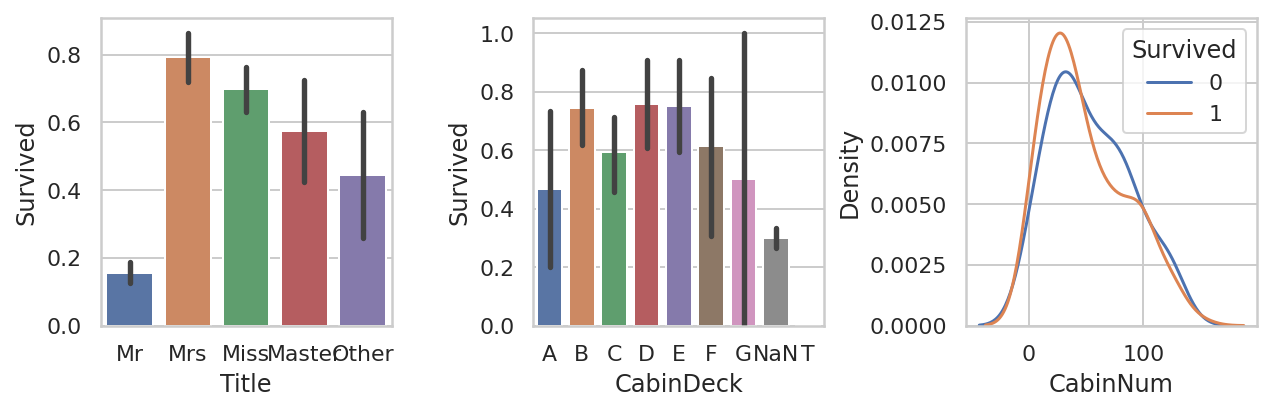

In [10]:
# Fix the one name that is in a different format from the rest.
train = train.replace(
    'Rothes, the Countess. of (Lucy Noel Martha Dyer-Edwards)', 
    'Dyer-Edwards, Countess. Lucy Noel Martha'
)

# Iterate over both train and test datasets.
for df in (train, test, train_test):
    
    # Extract title and last name.
    extracted = df['Name'].str.extract(r"^(.+?),\s(\w+)\.")
    df['LastName'] = extracted[0]
    df['Title'] = extracted[1]
    
    # Replace infrequent titles with 'Other'
    df.loc[~df['Title'].isin(['Mr', 'Mrs', 'Miss', 'Master']), 'Title'] = 'Other'

    # Extract cabin deck and number.
    df['CabinDeck'] = df['Cabin'].str.slice(0, 1).fillna('NaN')
    df['CabinNum'] = df['Cabin'].str.extract(r'(\d+)$').astype(float)
    
# Plot extracted values.
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
sns.barplot(data=train, x='Title', y='Survived', ax=axes[0])
sns.barplot(data=train, x='CabinDeck', y='Survived', ax=axes[1], order=sorted(train['CabinDeck'].unique()))
sns.kdeplot(data=train[train['Survived'] == 0], x='CabinNum', label='0', ax=axes[2])
sns.kdeplot(data=train[train['Survived'] == 1], x='CabinNum', label='1', ax=axes[2])
axes[2].legend(title='Survived')
plt.tight_layout()

Title is highly indicative of survival. This is heavily affected by sex and age, but could include novel information such as perceived social importance. 

The cabin deck does not seem to be indicative of survival. However, passengers without a known cabin number are less likely to survive. This could be because the cabin number is known for the majority of class A passengers. However, it could also include novel information, e.g. survivors would be able to share/record the cabin number after reaching shore.

Passengers with a higher cabin number are slightly less likely to survive. This could be affected by class status as well, as some decks have fewer number of cabins, but it could also inlude novel information such proximity to the stern/bow.

### Dealing with missing values

`Fare` is mising 1 value, `Embarked` is missing 2 values, `Age` is missing 20% of values, and `Cabin` is missing 77% of values, 

#### Fare
Since the fare depends on the ticket class, we can simply replace the missing value with the median value for the ticket class.

In [11]:
# Get passenger with the missing fare.
class_missing_fare = test.loc[test['Fare'].isna(), 'Pclass'].iloc[0]
# Get median fare for all passengers of the same class.
median_fare = test.loc[test['Pclass'] == class_missing_fare, 'Fare'].median()
# Fill the missing value.
test['Fare'] = test['Fare'].fillna(median_fare)

#### Embarked
As the majority of passengers embarked at Southampton, the missing values can be filled with it.

In [12]:
# Get the most common port of embarkation.
top_embarked = train['Embarked'].mode()[0]
# Fill the missing values.
train['Embarked'] = train['Embarked'].fillna(top_embarked)

#### Age

As age is predictive of survival, and we do not want to drop the rows with missing age values, we need to fill the missing values. Rather than just using random values following the overall distribution of ages, the missing ages can be approximated from other correlated features.

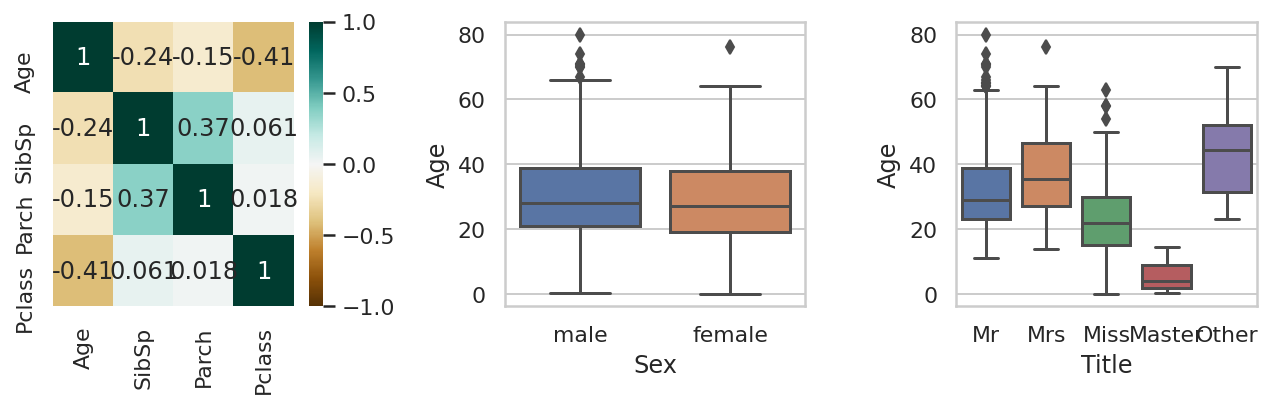

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
sns.heatmap(train_test[['Age', 'SibSp', 'Parch', 'Pclass']].corr(), cmap='BrBG', annot=True, vmin=-1, ax=axes[0])
sns.boxplot(data=train_test, x='Sex', y='Age', ax=axes[1])
sns.boxplot(data=train_test, x='Title', y='Age', ax=axes[2])
plt.tight_layout()

`SibSp`, `Parch`, `Pclass`, and `Title` all correlate with `Age`. We can, therefore, estimate the missing ages by looking at other passengers with similar values in those columns.

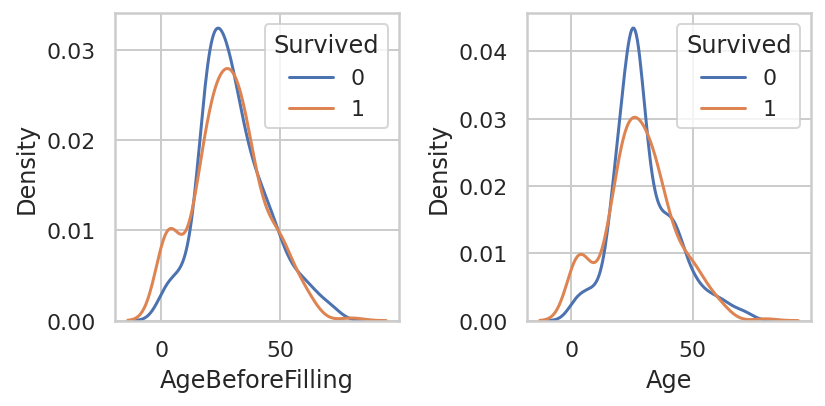

In [14]:
for df in (train, test, train_test):
    # Make a copy of column to compare afterwards.
    df['AgeBeforeFilling'] = df['Age'].copy()
    
    # Iterate all rows with missing ages.
    for i, row in df[df['Age'].isna()].iterrows():
        similar_subset = train_test[~train_test['Age'].isna()]
        
        # Iterate correlated columns in order of stronger correlation, reducing
        # the dataframe to passengers with the same values.
        for correlated_col in ['Title', 'Pclass', 'SibSp', 'Parch']:
            idx_value_match = similar_subset[correlated_col] == row[correlated_col]
            # Don't reduce the dataframe to less than 5 passengers, to avoid
            # getting outliers.
            if idx_value_match.sum() < 5:
                break
            similar_subset = similar_subset[idx_value_match]
        # Fill the missing age with the median age of the similar passengers.
        df.loc[i, 'Age'] = similar_subset['Age'].median()
        
# Plot the age distributions before and after filling values to ensure nothing
# odd happened.
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
for i, column in enumerate(['AgeBeforeFilling', 'Age']):
    sns.kdeplot(data=train[train['Survived'] == 0], x=column, label='0', ax=axes[i])
    sns.kdeplot(data=train[train['Survived'] == 1], x=column, label='1', ax=axes[i])
    axes[i].legend(title='Survived')
plt.tight_layout()

#### Cabin
The cabin number is indicative of survival, but the majority of passengers have missing cabin numbers. Similar to the age, we should check if any other values are correlated with the cabin number.

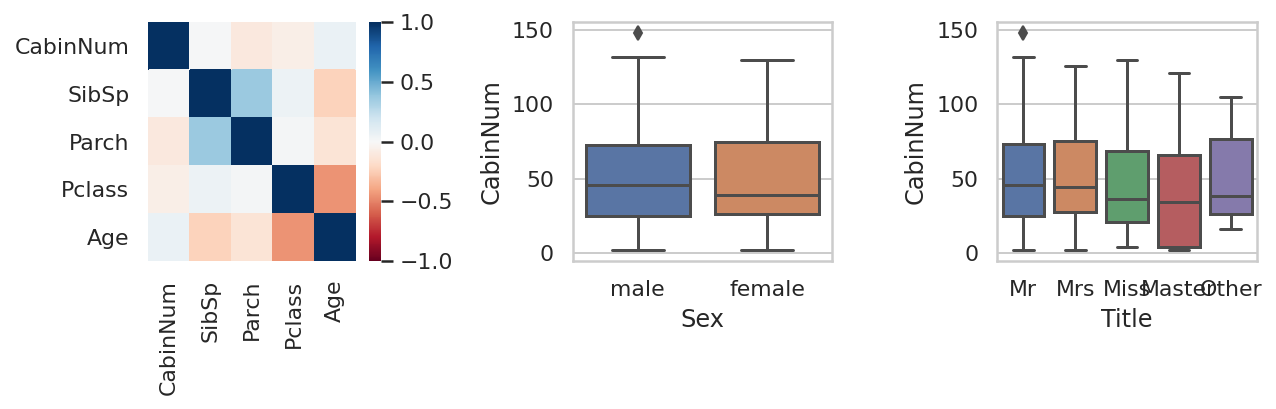

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
sns.heatmap(train_test[['CabinNum', 'SibSp', 'Parch', 'Pclass', 'Age']].corr(), cmap='RdBu', vmin=-1, ax=axes[0])
sns.boxplot(data=train_test, x='Sex', y='CabinNum', ax=axes[1])
sns.boxplot(data=train_test, x='Title', y='CabinNum', ax=axes[2])
plt.tight_layout()

Cabin number only has a very weak correlation with other values. The best solution may therefore be to simply fill missing values with the approximate middle of the ship, which is around cabin number 50.

In [16]:
# Fill missing cabin numbers with random values from the existing values.
for df in (train, test, train_test):
    df['CabinNum'] = df['CabinNum'].fillna(50)

## Feature generation

_[<sup>Return to beginning of notebook</sup>](#Kaggle-Titanic-challenge)_

### New features

#### Family size

The total family size could be an indicator of survival. In addition, the number of family members does not include fiancés, nannies, or good friends, so the number of passengers per ticket could hold additional information.

In [17]:
for df in (train, test, train_test):
    df['FamilySize'] = df['SibSp'] + df['Parch']
    df['PassengerPerTicket'] = train_test.assign(n=1).groupby('Ticket')['n'].transform('count')

#### Is the cabin known?

We found earlier that knowledge of the cabin is highly indicative of survival.

In [18]:
for df in (train, test, train_test):
    df['CabinIsKnown'] = (~df['Cabin'].isna()).astype(int)

#### Did relatives survive?

It is possible that families traveled together on the ship, made decisions together, and met a similar fate. We don't know which passengers traveled together, but we have three decent indicators, including a shared last name, a shared ticket, or a shared cabin.

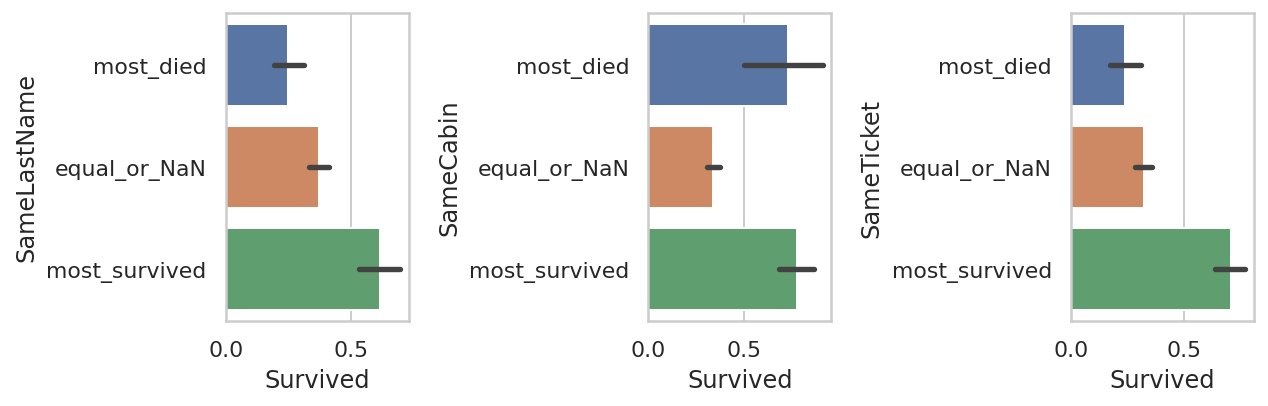

In [19]:
# Determine the status of others traveling with passenger.
for df in (train, test, train_test):
    df['SameLastName'] = titanic.status_of_others_sharing_factor('LastName', train, df)
    df['SameCabin'] = titanic.status_of_others_sharing_factor('Cabin', train, df)
    df['SameTicket'] = titanic.status_of_others_sharing_factor('Ticket', train, df)

# Plot the result.
sharing_columns = ('SameLastName', 'SameCabin', 'SameTicket')
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
for i, column in enumerate(sharing_columns):
    sns.barplot(data=train, y=column, x='Survived', ax=axes[i], order=('most_died', 'equal_or_NaN', 'most_survived'))
plt.tight_layout()

Passengers sharing the same last name and passengers with the same ticket number had similar fates. Passengers in the same cabin did not seem to have similar fates, likely because the cabin number was missing for the majority of passengers.

#### Fare per passenger

Since some tickets include multiple passengers, it is possibly that the fare is the price per ticket rather than the price per passenger. The fare per person may be a better indicator of survival than the fare per ticket.

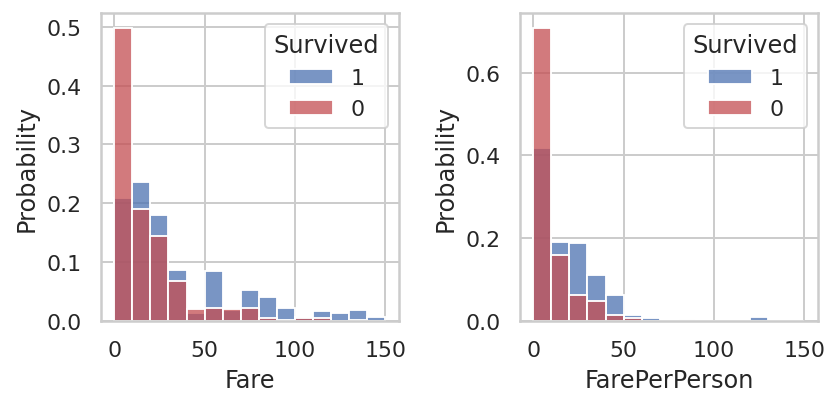

In [20]:
for df in (train, test, train_test):
    df['FarePerPerson'] = df['Fare'] / df['PassengerPerTicket']

columns = ['Fare', 'FarePerPerson']

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
for i, column in enumerate(columns):
    hist_kwargs = {'stat': 'probability', 'binrange': (0, 150), 'bins': 15}
    sns.histplot(data=train[train['Survived'] == 1], x=column, ax=axes[i], label='1', **hist_kwargs)
    sns.histplot(data=train[train['Survived'] == 0], x=column, ax=axes[i], label='0', color='r', **hist_kwargs)
    axes[i].legend(title='Survived')
plt.tight_layout()

The distributions are slightly different. The majority of high fares seemed to be due to multiple passengers on the same ticket. Either only use the fare per person, or try both to determine which is better.

### Drop unused columns

In [21]:
to_drop = ['Name', 'LastName', 'Cabin', 'CabinDeck', 'Ticket', 'AgeBeforeFilling', 'SameCabin']
for df in (train, test, train_test):
    df.drop(to_drop, axis=1, inplace=True)

### Converting categorical features to numerical

Convert categorical values to dummies (zeros or ones), including `Pclass`, since the relationship between upper and middle class may not be the same as the relationship between middle and lower class.

In [22]:
categorical_columns = ['Pclass', 'Sex', 'Embarked', 'Title', 'SameLastName', 'SameTicket']
train = pd.get_dummies(train, columns=categorical_columns)
test = pd.get_dummies(test, columns=categorical_columns)
train_test = pd.get_dummies(train_test, columns=categorical_columns)

### Binning numerical values

A few of the numerical columns can be binned to highlight ranges predictive of survival (e.g. children have higher survival rate, and passengers traveling alone had lower survival rate). 

In [23]:
for df in (train, test, train_test):
    # Is the passenger traveling alone?
    df['IsAlone'] = (df['FamilySize'] == 0).astype(int)
    df['SingleTicket'] = (df['PassengerPerTicket'] == 1).astype(int)
    # Binned fares and ages.
    df['FareBinned'] = pd.cut(df['Fare'], [-np.inf, 0, 10, 20, 30, np.inf]).cat.codes
    df['FarePerPersonBinned'] = pd.cut(df['FarePerPerson'], [-np.inf, 0, 10, 20, 30, np.inf]).cat.codes
    df['AgeBinned'] = pd.cut(df['Age'], [-np.inf, 10, 20, 30, 40, 50, np.inf]).cat.codes
    # Is the cabin living in the stern or bow of the ship?
    df['CabinStern'] = (df['CabinNum'] < 50).astype(int)
    df['CabinBow'] = (df['CabinNum'] > 50).astype(int)

### Scaling numerical features

For some of the models, the large numerical values need to be scaled for better performance.

In [24]:
numerical_columns = [
    'Age', 'SibSp', 'Parch', 'FamilySize', 'CabinNum', 'Fare', 'FarePerPerson',
    'PassengerPerTicket', 'FareBinned', 'FarePerPersonBinned', 'AgeBinned'
]

scaler = preprocessing.StandardScaler().fit(train_test[numerical_columns])
for df in (train, test, train_test):
    df[numerical_columns] = scaler.transform(df[numerical_columns])
    
train.head()

,Survived,Age,SibSp,Parch,Fare,CabinNum,FamilySize,PassengerPerTicket,CabinIsKnown,FarePerPerson,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,SameLastName_equal_or_NaN,SameLastName_most_died,SameLastName_most_survived,SameTicket_equal_or_NaN,SameTicket_most_died,SameTicket_most_survived,IsAlone,SingleTicket,FareBinned,FarePerPersonBinned,AgeBinned,CabinStern,CabinBow
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,-0.546534,0.481288,-0.445,-0.503402,-0.000958,0.073352,-0.619174,0,-0.554050,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,-1.043349,-0.704621,-0.280081,0,0
2,1,0.644373,0.481288,-0.445,0.734222,2.192673,0.073352,-0.057108,1,1.541205,1,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1.371048,2.110280,0.499974,0,1
3,1,-0.248807,-0.479087,-0.445,-0.490356,-0.000958,-0.558346,-0.619174,0,-0.504236,0,0,1,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,1,-1.043349,-0.704621,-0.280081,0,0
4,1,0.421078,0.481288,-0.445,0.382778,4.574328,0.073352,-0.057108,1,0.870257,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1.371048,1.171979,0.499974,0,1
5,0,0.421078,-0.479087,-0.445,-0.487940,-0.000958,-0.558346,-0.619174,0,-0.495011,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,1,-1.043349,-0.704621,0.499974,0,0


### Check features

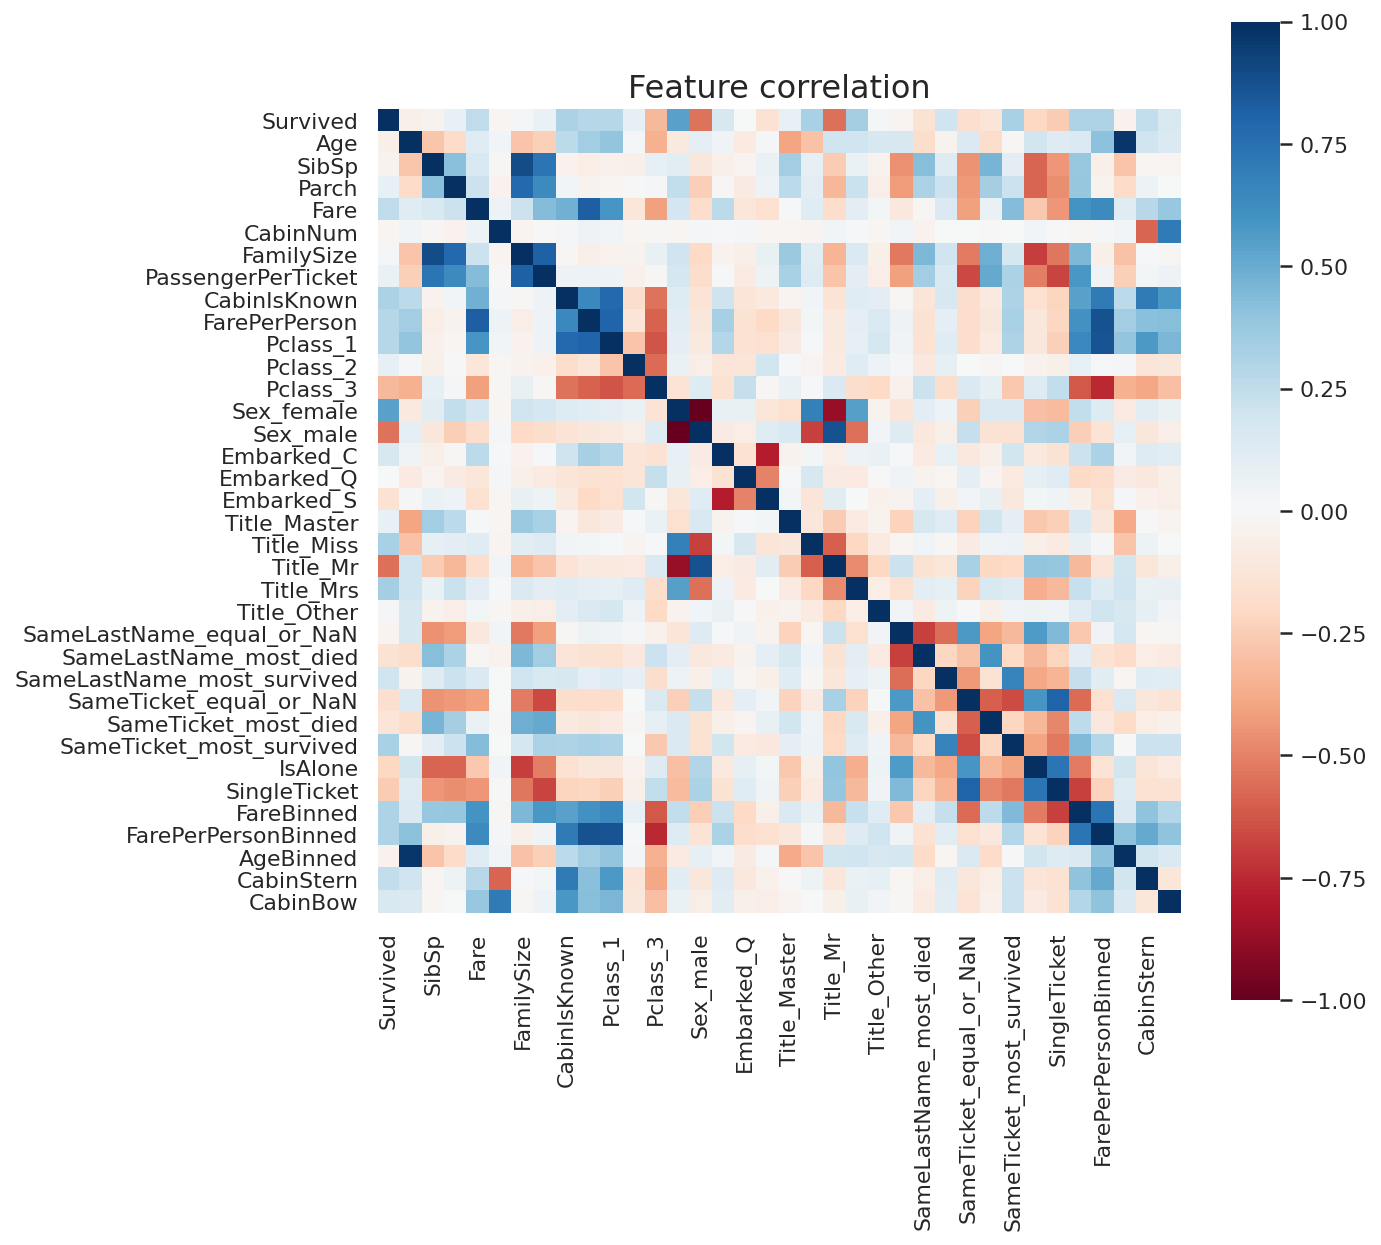

In [25]:
plt.figure(figsize=(9, 9))
plt.title('Feature correlation', size=16)
sns.heatmap(train.corr(), vmin=-1, square=True, cmap='RdBu');

Not too many features are strongly correlated, except for the obvious candidates (e.g. binned vs not binned, ticket class vs fare, and dummies of the same categorical columns, etc). 

## Modeling

_[<sup>Return to beginning of notebook</sup>](#Kaggle-Titanic-challenge)_

### Base models

Let's compare the most common classifiers to determine which is likely to do better after tuning. The models will be evaluated by the mean accuracy of stratified k-fold cross-validation.

100%|██████████| 14/14 [00:00<00:00, 90757.74it/s]


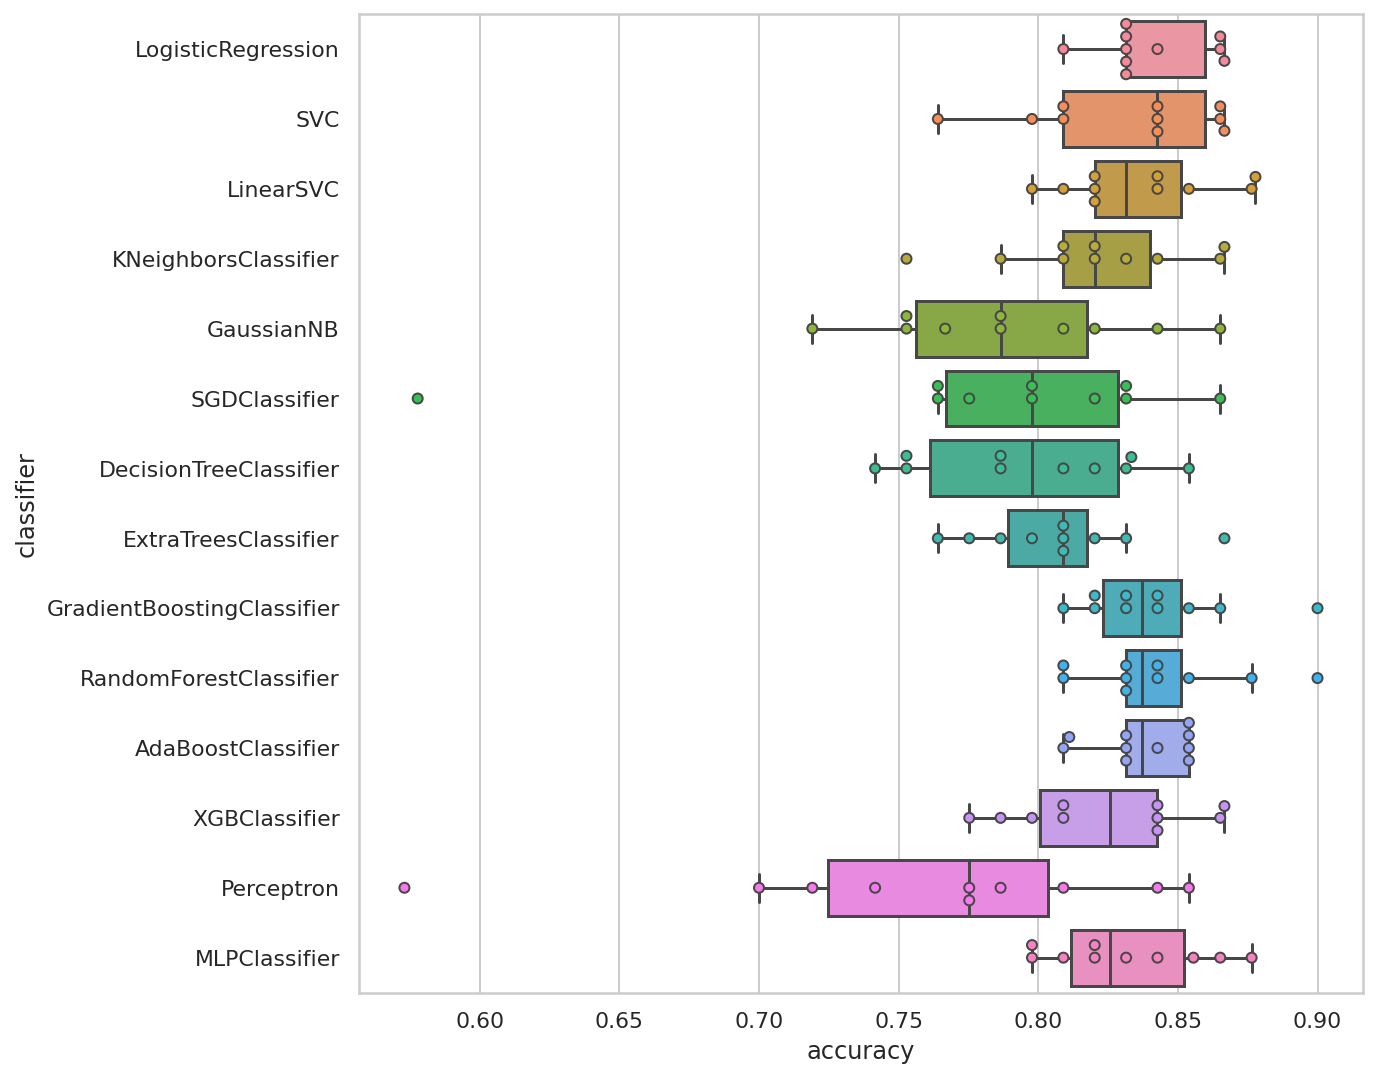

In [88]:
# Set random state for reproducibility.
random_state = 42

# Initialize cross validation object and classifiers with default parameters.
kfold = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
classifiers = [
    LogisticRegression(random_state=random_state),
    SVC(random_state=random_state),
    LinearSVC(random_state=random_state),
    KNeighborsClassifier(),
    GaussianNB(),
    SGDClassifier(random_state=random_state),
    DecisionTreeClassifier(random_state=random_state),
    ExtraTreesClassifier(random_state=random_state),
    GradientBoostingClassifier(random_state=random_state),
    RandomForestClassifier(random_state=random_state),
    AdaBoostClassifier(random_state=random_state),
    XGBClassifier(random_state=random_state),
    Perceptron(random_state=random_state),
    MLPClassifier(random_state=random_state)
]

# Train models and store accuracy scores in dataframe.
X_train = train.drop('Survived', axis=1)
y_train = train['Survived']
cv_results = pd.DataFrame(index=range(10))
for classifier in tqdm(classifiers):
    cv_results[classifier.__class__.__name__] = model_selection.cross_val_score(
        classifier, X_train, y_train, scoring='accuracy', cv=kfold, n_jobs=15
    )

# Plot accuracy scores.
cv_results = pd.melt(cv_results, var_name='classifier', value_name='accuracy')
plt.figure(figsize=(9, 9))
sns.boxplot(data=cv_results, x='accuracy', y='classifier', showfliers=False)
sns.swarmplot(data=cv_results, x='accuracy', y='classifier', size=5, linewidth=1)
plt.show()

The best performing classifiers are logistic regression, SVC, GradientBoosting, RandomForest, and AdaBoost. Going forward, we will be tuning these models to see which perform better or whether an ensemble approach is the best choice.

### Hyperparameter tuning

In [42]:
0/0 # Stop here when running everything to prevent accidental submission

ZeroDivisionError: division by zero

In [ ]:
test_submission = (test['Sex'] != 'male').rename('Survived').astype(int)
kaggle_api.submit('titanic', test_submission, 'Test submission from API that should fail')